In [1]:
import pandas as pd
import os
import numpy as np
from Bio import SeqIO
from collections import Counter
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
tdict = {}
translate_df = pd.read_csv("../aux_data/GCF_002891405.2_Csec_1.0_assembly_report.txt", comment="#", sep='\t', header=None)
for i, k in translate_df.iterrows():
    tdict[k[6]]=k[4]

In [3]:
braker_intron = pd.read_csv('../aux_data/GCF_002891405.2_Csec_1.0_genomic_with_introns.gff', sep='\t', comment='#', header=None)

In [4]:
# run on genetic elements within the gene:
braker_intron.columns = ['scaffold', 'source', 'type', 'start', 'stop', 'n', 'strand', 'n2', 'idstring']
braker_intron['scaffold2'] = [tdict[i] for i in braker_intron.scaffold]

In [5]:
# get only genes:
braker_genes = braker_intron.loc[braker_intron['type'].isin(['gene'])]


In [6]:
#braker_genes

In [7]:
def create_and_submit_sbatch(batch, chunk):
    name="RHO_Csec_gene_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Csec_rho_per_gene_with_buffer.py --input {chunk} --flanksize 50000 --flankbuffer 10000".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [8]:
#split into chunks and write them
chunk_n = 200
ss_split = np.array_split(braker_genes, chunk_n)

In [9]:
cfiles = []
for i, k in enumerate(ss_split):
    #print(i)
    chunkname = "/home/tilman/termites/TR_20230707/TR_20230707_per_gene_analysis/Csec/intermediate_data/ss_chunks/ss_chunk{chunk_i}.chunk".format(chunk_i=i)
    #k.to_csv(chunkname, sep='\t')
    create_and_submit_sbatch(batch=i, chunk=chunkname)

Submitted batch job 41128453
Submitted batch job 41128454
Submitted batch job 41128455
Submitted batch job 41128456
Submitted batch job 41128457
Submitted batch job 41128458
Submitted batch job 41128459
Submitted batch job 41128460
Submitted batch job 41128461
Submitted batch job 41128462
Submitted batch job 41128463
Submitted batch job 41128464
Submitted batch job 41128465
Submitted batch job 41128466
Submitted batch job 41128467
Submitted batch job 41128468
Submitted batch job 41128469
Submitted batch job 41128470
Submitted batch job 41128471
Submitted batch job 41128472
Submitted batch job 41128473
Submitted batch job 41128474
Submitted batch job 41128475
Submitted batch job 41128476
Submitted batch job 41128477
Submitted batch job 41128478
Submitted batch job 41128479
Submitted batch job 41128480
Submitted batch job 41128481
Submitted batch job 41128482
Submitted batch job 41128483
Submitted batch job 41128484
Submitted batch job 41128485
Submitted batch job 41128486
Submitted batc

In [7]:
rho_chunks =  [ i for i in os.listdir('/home/tilman/termites/TR_20230707/TR_20230707_per_gene_analysis/Csec/intermediate_data/ss_chunks/') if i.endswith('flanksize50000_buffer10000.rho')]
rho_chunks = [i for i in rho_chunks if not i.startswith('test')]
rho_chunks_df = pd.concat([pd.read_csv(os.path.join("/home/tilman/termites/TR_20230707/TR_20230707_per_gene_analysis/Csec/intermediate_data/ss_chunks/",i), sep='\t', header=None) for i in rho_chunks])
rho_chunks_df.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank','weighted_mean_rho_dflank', 'idstring']
rho_chunks_df = rho_chunks_df.replace('no_overlap_bin', np.nan)
rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']] = rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']].astype(float)
rho_chunks_df.to_csv('../20230919_Csec_rho_per_gene_and_50kbflank_with_10kbbuffer_newfilt.tsv', sep='\t')

In [12]:
braker_exin = braker_intron.loc[braker_intron['type'].isin(['exon', 'intron'])]


In [9]:
rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']] = rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']].astype(float)

In [10]:
rho_chunks_dfmelt = rho_chunks_df.melt(id_vars=['idstring', 'scaffold'], value_vars=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank',] )


In [67]:
#rho_chunks_dfmelt = rho_chunks_dfmelt.replace('no_overlap_bin', np.nan)
#rho_chunks_dfmelt['value'] = rho_chunks_dfmelt['value'].astype(float)

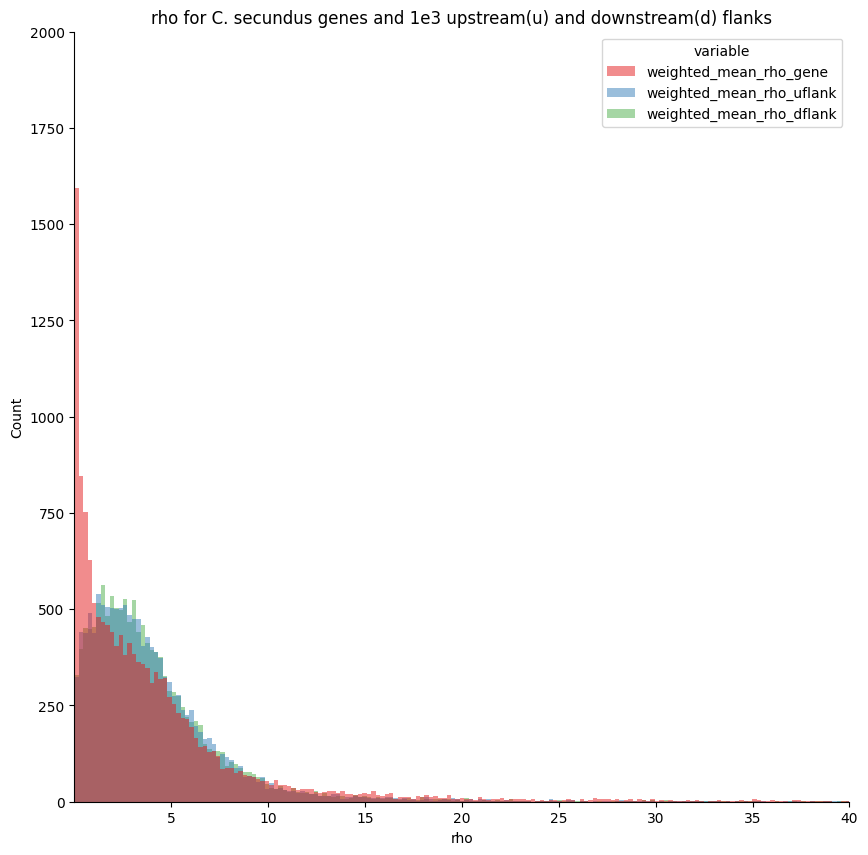

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=rho_chunks_dfmelt, x="value", hue="variable",linewidth=0, palette = ['#e41a1c','#377eb8','#4daf4a'])

ax.set_xlim(0.01,40)
ax.set_ylim(0.00,2000)
ax.set_title('rho for C. secundus genes and 1e3 upstream(u) and downstream(d) flanks')
ax.set_xlabel('rho')

sns.despine()
plt.show()

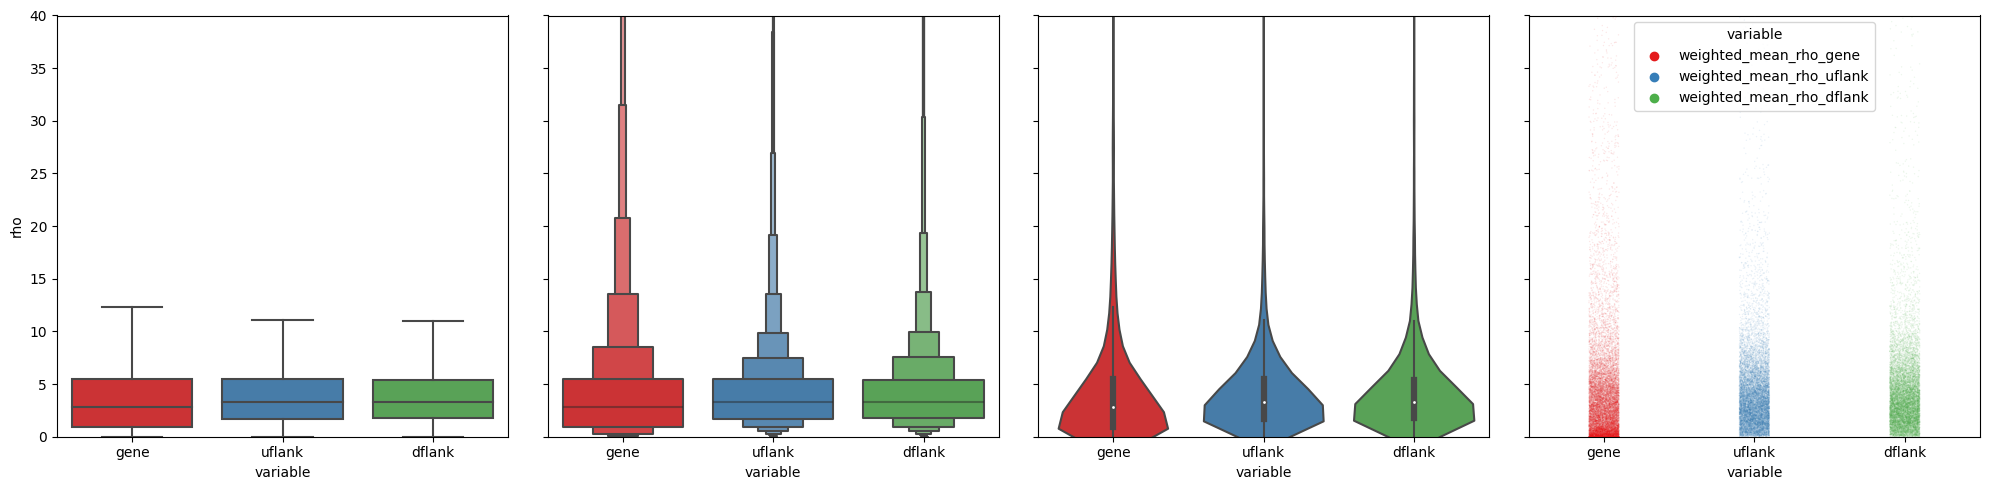

In [12]:

fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')

ax.set_ylim(0,40)

plt.tight_layout()
plt.show()

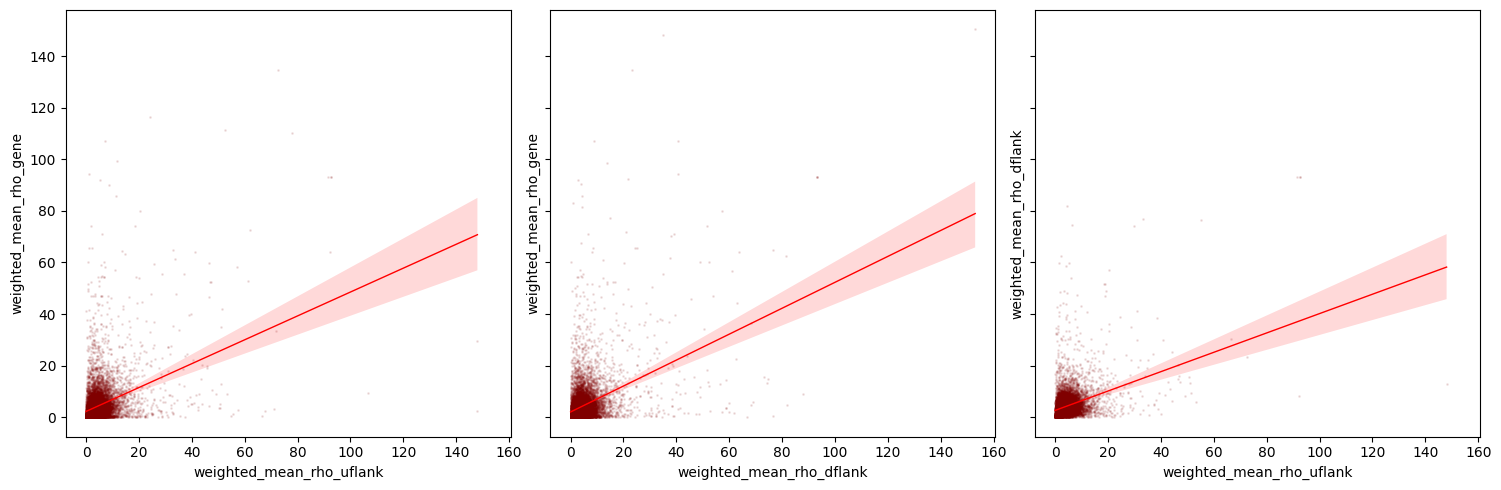

In [14]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

plt.tight_layout()
#ax.set_ylim(0,3)
#ax.set_xlim(0,3)

plt.show()

In [15]:
rho_chunks_exin =  [ i for i in os.listdir("../ex_in_chunks/")]

In [24]:
rho_chunks_exin

['braker_chunk_4.gene.ex_in.cpg',
 'braker_chunk_11.gff3_chunk',
 'braker_chunk_39.gene.ex_in.cpg',
 'braker_chunk_10.gff3_chunk',
 'braker_chunk_0.gene.ex_in.cpg',
 'braker_chunk_15.gene.ex_in.cpg',
 'braker_chunk_12.gene.ex_in.cpg',
 'braker_chunk_21.gene.ex_in.cpg',
 'braker_chunk_2.gene.ex_in.cpg',
 'braker_chunk_23.gene.ex_in.cpg',
 'braker_chunk_19.gene.ex_in.cpg',
 'braker_chunk_3.gff3_chunk',
 'braker_chunk_35.gene.ex_in.cpg',
 'braker_chunk_29.gene.ex_in.cpg',
 'braker_chunk_25.gff3_chunk',
 'braker_chunk_14.gff3_chunk',
 'braker_chunk_0.gff3_chunk',
 'braker_chunk_18.gff3_chunk',
 'braker_chunk_48.gene.ex_in.cpg',
 'braker_chunk_24.gff3_chunk',
 'braker_chunk_37.gff3_chunk',
 'braker_chunk_31.gene.ex_in.cpg',
 'braker_chunk_46.gene.ex_in.cpg',
 'braker_chunk_41.gene.ex_in.cpg',
 'braker_chunk_13.gff3_chunk',
 'braker_chunk_42.gff3_chunk',
 'braker_chunk_36.gff3_chunk',
 'braker_chunk_22.gff3_chunk',
 'braker_chunk_29.gff3_chunk',
 'braker_chunk_37.gene.ex_in.cpg',
 'braker_ch

In [15]:
rho_chunks_exin =  [ i for i in os.listdir("./exin_chunk2") if i.endswith(".rho")]

In [16]:
rho_chunks_exin = [i for i in rho_chunks_exin if not i.startswith('test')]
rho_chunks_exin_df = pd.concat([pd.read_csv(os.path.join("./exin_chunk2/",i), sep='\t', index_col=0, header=None) for i in rho_chunks_exin])
#rho_chunks_exin_df.to_csv('./20230717_Csec_rho_exons_and_introns.tsv', sep='\t')

In [17]:
rho_chunks_exin_df.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [18]:
braker_intron.columns

Index(['scaffold', 'source', 'type', 'start', 'stop', 'n', 'strand', 'n2',
       'idstring', 'scaffold2'],
      dtype='object')

In [19]:
rho_chunks_exin_df.columns = list(braker_intron.columns)+['RHO']

In [20]:
rho_chunks_exin_df.columns

Index(['scaffold', 'source', 'type', 'start', 'stop', 'n', 'strand', 'n2',
       'idstring', 'scaffold2', 'RHO'],
      dtype='object')

In [24]:
rho_chunks_exin_df.RHO = rho_chunks_exin_df.RHO.replace('no_overlap_bin', np.nan).astype(float)

In [25]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

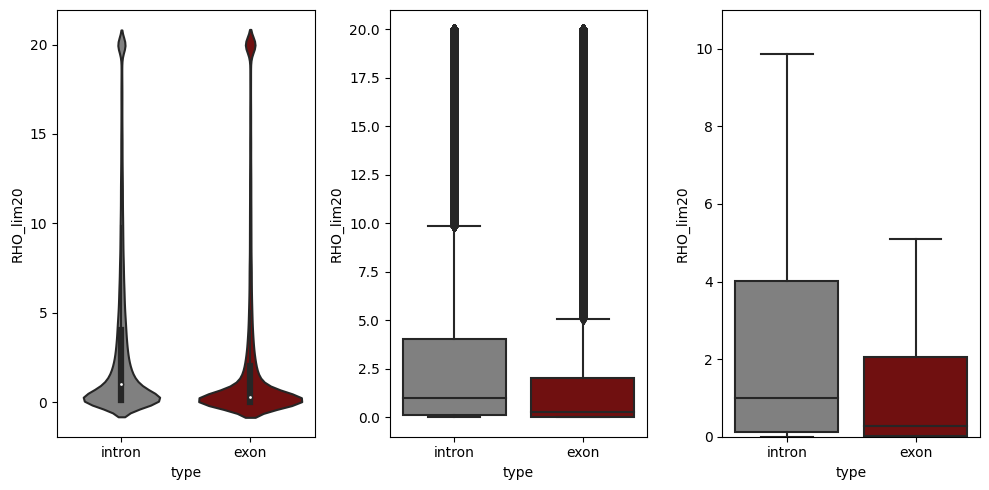

In [26]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax2.set_ylim(0,11)
plt.tight_layout()
plt.show()

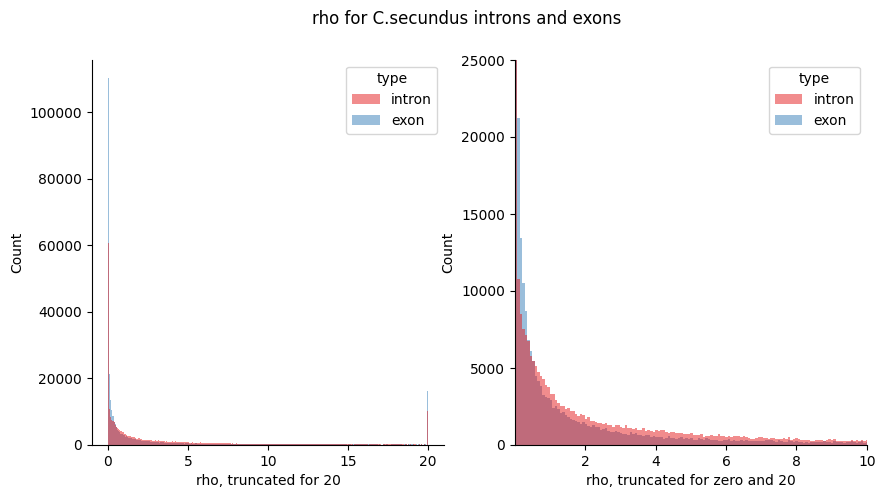

In [27]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for C.secundus introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,10)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

sns.despine()
plt.show()

In [62]:
#braker_intron

In [28]:
rho_chunks_exin_df['RHO'].mean()

3.6306370591710246

In [29]:
rho_chunks_exin_df.groupby('type')['RHO'].mean()

type
exon      3.558582
intron    3.711299
Name: RHO, dtype: float64

In [30]:
rho_chunks_exin_df.groupby('type')['RHO'].sem()

type
exon      0.017638
intron    0.014387
Name: RHO, dtype: float64

In [31]:
rho_chunks_exin_df.groupby('type')['RHO'].std()

type
exon      9.801586
intron    7.556328
Name: RHO, dtype: float64

In [32]:
rho_chunks_dfmelt.groupby('variable')['value'].mean()

variable
weighted_mean_rho_dflank    4.432077
weighted_mean_rho_gene      4.777806
weighted_mean_rho_uflank    4.373883
Name: value, dtype: float64

In [33]:
rho_chunks_dfmelt.groupby('variable')['value'].sem()

variable
weighted_mean_rho_dflank    0.046994
weighted_mean_rho_gene      0.066293
weighted_mean_rho_uflank    0.045769
Name: value, dtype: float64

In [34]:
rho_chunks_dfmelt.groupby('variable')['value'].std()

variable
weighted_mean_rho_dflank    5.502758
weighted_mean_rho_gene      8.121650
weighted_mean_rho_uflank    5.354132
Name: value, dtype: float64

NameError: name 'rho_chunks_dfmelt' is not defined

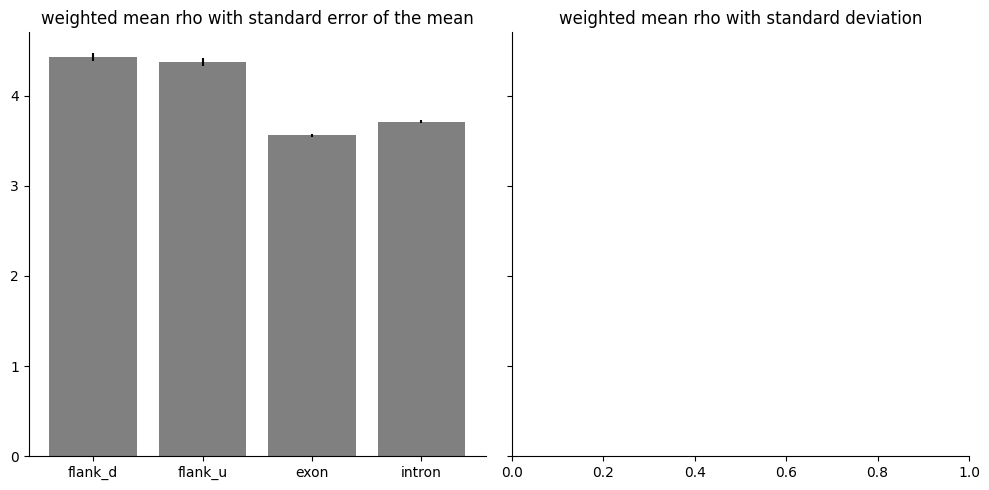

In [35]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharey=True)
ax.bar(height = [4.432077,4.373883, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.046994,0.045769,0.017638,0.014387], color='grey')
#ax1.bar(height = [4.457875,4.463503, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [9.954115,10.160580,9.801586,7.556328], color='grey')

ax.set_title("weighted mean rho with standard error of the mean")
ax1.set_title("weighted mean rho with standard deviation")
sns.despine()
plt.tight_layout()
ax.set_ylim(0,)
plt.show()

In [36]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loßc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.type =='intron']['RHO'].dropna()

0
511495     5.475161
511498     1.480505
511501     8.133196
511504     8.948158
511507    10.818923
            ...    
768541     0.639945
768544     7.392937
768547    14.547049
768550     5.716653
768553    15.201666
Name: RHO, Length: 276269, dtype: float64

In [37]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [38]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.058     0.945    -0.212     0.328
 (0 - 2)      0.873     0.000     0.679     1.068
 (0 - 3)      0.721     0.000     0.525     0.916
 (1 - 0)     -0.058     0.945    -0.328     0.212
 (1 - 2)      0.815     0.000     0.620     1.010
 (1 - 3)      0.663     0.000     0.467     0.858
 (2 - 0)     -0.873     0.000    -1.068    -0.679
 (2 - 1)     -0.815     0.000    -1.010    -0.620
 (2 - 3)     -0.153     0.000    -0.211    -0.094
 (3 - 0)     -0.721     0.000    -0.916    -0.525
 (3 - 1)     -0.663     0.000    -0.858    -0.467
 (3 - 2)      0.153     0.000     0.094     0.211

